<h1>MLP Predictor for stock data</h1>

<h3>Author: Danilo Filippo Reiszel Pereira</h3>
<strong>Univesidade Federal do Rio de Janeiro</strong>

<p>This notebook contains the creation several Multi-layer Perceptron models to predict D+1 closing prices of stocks</p>

In [1]:
import sys, os
sys.path.append('../src')
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralstocks.dataacquisition import *
from neuralstocks.plots import *
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

%matplotlib inline

Using TensorFlow backend.


<h3>Global Params</h3>

Setting global params such as directory of data, save directories and plot params

In [2]:
dataPath = '../../data'
assetType = 'stocks'
asset = 'PETR4'
frequency = 'diario'
filePath = dataPath + '/' + assetType + '/' + asset + '/' + frequency + '/' + asset + '.CSV'

pathPETR4 = '../../data/stocks/PETR4/diario/PETR4.CSV'
pathIBOV = '../../data/indexes/IBOV/diario/IBOV.CSV'
pathUSDBRL = '../../data/forex/USDBRL/diario/USDBRL.CSV'

decomposeModel = 'additive'

saveVarDir = './Variables'
if not os.path.exists(saveVarDir):
    os.makedirs(saveVarDir)
    print('saveVarDir created')
else:
    print('saveVarDir already exists!')
saveFigDir = './Figures'
if not os.path.exists(saveFigDir):
    os.makedirs(saveFigDir)
    print('saveFigDir created')
else:
    print('saveFigDir already exists!')
saveModelDir = './Models'
if not os.path.exists(saveModelDir):
    os.makedirs(saveModelDir)
    print('saveModelDir created')
else:
    print('saveModelDir already exists!')
saveFormat = 'png'

plt.rcParams['font.weight'] = 'bold'
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

saveVarDir already exists!
saveFigDir already exists!
saveModelDir already exists!


<h3>Data Acquisition and Preprocessing</h3>

Gathers and preprocess data. Data from auxiliary time series (such as IBOV index and USDBRL exchange rate) is also gathered, though tipically less indicators are calculated for this series. Trend Extraction is applied to desired series.

<strong>List of indicators applied to main time series: </strong>
<ul>
    <li>Mean and Standard Deviation, 20 periods</li>
    <li>Returns Calculations:
        <ul>
            <li>Close<sub>d</sub> / Close<sub>d-1</sub></li>
            <li>Close<sub>d</sub> / Open<sub>d</sub></li>
            <li>High<sub>d</sub> / Close<sub>d</sub></li>
            <li>Low<sub>d</sub> / Close<sub>d</sub></li>
        </ul>
    </li>
    <li>EMAs:
        <ul>
            <li>Close, 17 periods</li>
            <li>Close, 72 periods</li>
            <li>Close, 200 periods</li>
            <li>Volume, 21 periods</li>
        </ul>
    </li>
    <li>MACD, fast EMA = 12 periods, slow EMA = 26 periods, signal EMA = 9 periods</li>
    <li>Bollinger Bands, 20 periods</li>
    <li>On-Balance Volume (OBV)</li>
</ul>

<strong>Parameters for trend extraction:</strong>
<ul>
    <li>Column: Close</li>
    <li>Decompose model: Additive</li>
    <li>Fitting Order: 1 (by default)</li>
    <li>Window Size: 6</li>
    <li>Fitting Weigths Model: Autocorrelation</li>
    <li>Fitting Weigths Model Window Size: 18</li>
</ul>

In [3]:
init_time = time.time()
PETR4 = acquireData(filePath = pathPETR4,
                    replicateForHolidays = True,
                    meanStdLen = 20,
                    returnCalcParams = [['Close'], 
                                        ['Close', 'Open'],
                                        ['High', 'Close' ],
                                        ['Low', 'Close']],
                    EMAparams = [{'column': 'Close', 'lenght': 17}, 
                                 {'column': 'Close', 'lenght': 72}, 
                                 {'column': 'Close', 'lenght': 200}, 
                                 {'column': 'Volume', 'lenght': 21}],
                    MACDParams = [{'fast_lenght': 12, 'slow_lenght': 26, 'signal_lenght': 9}],
                    BBParams = [{'lenght': 20}],
                    OBVParams = [{'lenght': None}],
                    deTrendParams = {'column': 'Close', 'window': 6, 'model': decomposeModel, 
                                     'weightModel': 'window_acorr', 'weightModelWindow': 18},
                    colPrefix = 'PETR4',
                    dropNan = True
                   )

IBOV = acquireData(filePath = pathIBOV,
                    replicateForHolidays = True,
                    meanStdLen = 20,
                    returnCalcParams = [['Close'], 
                                        ['Close', 'Open'],
                                        ['High', 'Close' ],
                                        ['Low', 'Close']],
                    EMAparams = [{'column': 'Close', 'lenght': 17}, 
                                 {'column': 'Close', 'lenght': 72}, 
                                 {'column': 'Close', 'lenght': 200}],
                    colPrefix = 'IBOV',
                    dropNan = True
                  )

USDBRL= acquireData(filePath = pathUSDBRL,
                    replicateForHolidays = True,
                    meanStdLen = 20,
                    returnCalcParams = [['Close'], 
                                        ['Close', 'Open'],
                                        ['High', 'Close' ],
                                        ['Low', 'Close']],
                    EMAparams = [{'column': 'Close', 'lenght': 17}, 
                                 {'column': 'Close', 'lenght': 72}, 
                                 {'column': 'Close', 'lenght': 200}],
                    colPrefix = 'USDBRL',
                    dropNan = True
                   )


end_time = time.time()
print 'Time to acquire and process data: '+str(end_time-init_time)+' seconds'

Time to acquire and process data: 11.3536319733 seconds


<h3>Dataset concatenation and selection of wich features to feed to the model</h3>

In [4]:
df = pd.concat([PETR4, IBOV, USDBRL], axis = 1).dropna()

columnsToUse = ['PETR4_Close_resid', 
                'PETR4_Close_rollStd20', 
                'PETR4_Close_returns', 'PETR4_Close/Open_returns', 'PETR4_High/Close_returns', 'PETR4_Low/Close_returns', 
                'PETR4_Close_EMA17_logdiff', 'PETR4_Close_EMA72_logdiff', 'PETR4_Close_EMA200_logdiff', 'PETR4_Volume_EMA21_logdiff', 
                'PETR4_MACD_12_26_9', 'PETR4_MACDsignal_12_26_9', 'PETR4_Bollinger%b_20', 'PETR4_OBV', 
                'PETR4_Holiday',
                'IBOV_Close_rollStd20', 
                'IBOV_Close_returns', 'IBOV_Close/Open_returns', 'IBOV_High/Close_returns', 'IBOV_Low/Close_returns',
                'IBOV_Close_EMA17_logdiff', 'IBOV_Close_EMA72_logdiff', 'IBOV_Close_EMA200_logdiff',
                'USDBRL_Close_rollStd20', 
                'USDBRL_Close_returns', 'USDBRL_Close/Open_returns', 'USDBRL_High/Close_returns', 'USDBRL_Low/Close_returns',
                'USDBRL_Close_EMA17_logdiff', 'USDBRL_Close_EMA72_logdiff', 'USDBRL_Close_EMA200_logdiff',
               ]

<h3>Creation of feature matrix and output array, split of data in Train and Test sets</h3>

In [5]:
xTrain, yTrain, xTest, yTest = prepData(df = df, 
                                        columnsToUse = columnsToUse, columnToPredict = 'PETR4_Close_resid', 
                                        nDelays = 10, testSetSize = len(df['2017'])
                                       )

numberOfTrainBatches = len(xTrain)
numberOTestBatches = len(xTest)
numberOfTrainInputs = len(xTrain[0])
print 'Number of train batches: {}'.format(numberOfTrainBatches)
print 'Number of test batches: {}'.format(numberOTestBatches)
print 'Number of inputs per batch: {}'.format(numberOfTrainInputs)

Number of train batches: 4185
Number of test batches: 175
Number of inputs per batch: 40


<h3>Feature Scalling</h3>

Technique used: Normalisation

In [6]:
xNormScaler = MinMaxScaler(feature_range = (-1,1))
xNormScaler.fit(xTrain)

yNormScaler = MinMaxScaler(feature_range = (-1,1))
yNormScaler.fit(yTrain)

xNormTrain = xNormScaler.transform(xTrain)
xNormTest  = xNormScaler.transform(xTest)

yNormTrain = yNormScaler.transform(yTrain)

<h3>Parameters for traning</h3>

In [7]:
inputDim = xTrain.shape[1]

nFolds = 10 # number of times a topology will be trained
maxNeuronsInHiddenLayer = 40 # upper limit for number of neurons in hidden layer

# optimizer definition
optimizer = optimizers.SGD(lr=0.003, momentum=0.00, decay=0.0, nesterov=False)

# callbacks definitions
earlyStopping = EarlyStopping(monitor='val_loss', patience=25, mode='auto')

<h3>Training of MLP model</h3>

In [8]:
init_time = time.time()

bestNormValLoss = np.Inf
bestNormFitHistory = None
bestNormHiddenLayer = 1

for nNeurons in range(1, maxNeuronsInHiddenLayer + 1):
    modelCheckpoint = ModelCheckpoint('./Models/PETR4_MLPi40h{}_norm.h5'.format(nNeurons), save_best_only=True)
    for fold in range(nFolds):
        model = Sequential([Dense(nNeurons, activation = 'tanh', input_dim = inputDim),
                            Dense(1, activation = 'linear')
                           ])
        model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mae'])

        fitHistory = model.fit(xNormTrain, 
                               yNormTrain, 
                               epochs = 2000,
                               verbose = 0,
                               shuffle = True,
                               validation_split = 0.15, 
                               callbacks = [modelCheckpoint,
                                            earlyStopping])
        
        if min(fitHistory.history['val_loss']) < bestNormValLoss:
            bestNormValLoss = min(fitHistory.history['val_loss'])
            bestNormFitHistory = fitHistory
            bestNormHiddenLayer = nNeurons

end_time = time.time()

print 'Time to fit all models: '+str(end_time-init_time)+' seconds'

Time to fit all models: 15693.5170019 seconds


In [9]:
bestNormModel = load_model('./Models/PETR4_MLPi40h{}_norm.h5'.format(bestNormHiddenLayer))
bestNormModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_513 (Dense)            (None, 26)                1066      
_________________________________________________________________
dense_514 (Dense)            (None, 1)                 27        
Total params: 1,093
Trainable params: 1,093
Non-trainable params: 0
_________________________________________________________________


In [10]:
#SVG(model_to_dot(bestNormModel).create(prog='dot', format='svg'))

<h3>Plot of RMSE per epoch, for Training Set and Validation Set</h3>
Note: Validation set is not always the same as Test Set; it's randomly generated from the Training Set

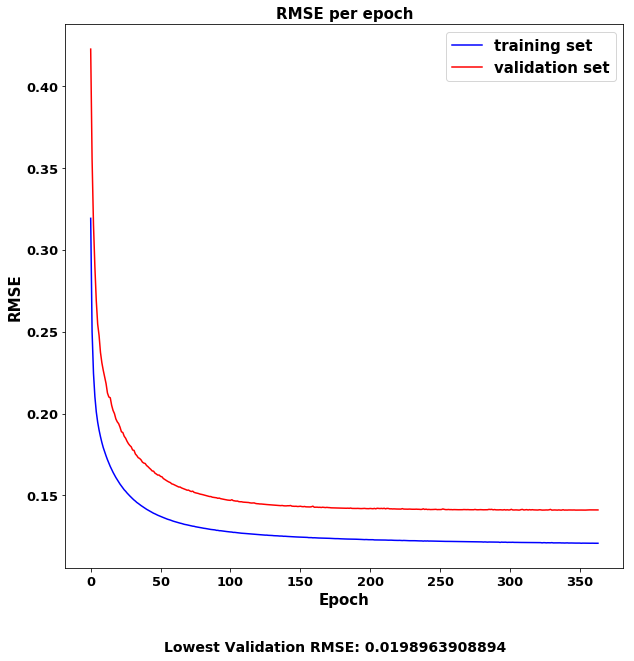

In [11]:
fig, ax = plt.subplots(figsize = (10,10), nrows = 1, ncols = 1)
ax.set_title('RMSE per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
trainigSet, = ax.plot(np.sqrt(bestNormFitHistory.history['loss']), 'b', label = 'trainig set')
validationSet, = ax.plot(np.sqrt(bestNormFitHistory.history['val_loss']), 'r', label = 'validation set')
plt.legend(handles=[trainigSet, validationSet], labels=['training set', 'validation set'], prop={'size': 15})
plt.figtext(0.5,  0.010, 'Lowest Validation RMSE: {}'.format(min(bestNormFitHistory.history['val_loss'])), size = 14, horizontalalignment = 'center')
fig.savefig('{}/{}.{}'.format(saveFigDir, 'PETR4_MLP_norm', 'pdf'), bbox_inches='tight')

<h3>Plot of predictions made using the Test Set</h3>

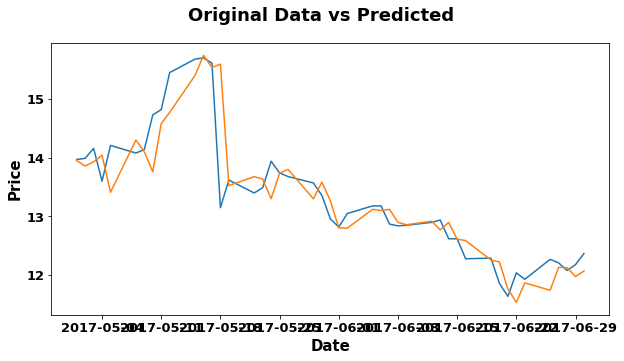

In [12]:
predictionsNorm = bestNormModel.predict(xNormTest)
predictionsNorm = yNormScaler.inverse_transform(predictionsNorm)
predictionsNorm_clean = []
for p in predictionsNorm:
    predictionsNorm_clean.extend(p)
predictionsNormSeries = pd.Series(predictionsNorm_clean, index = df['2017'].index)

plotSeries([df['PETR4_Close_trend']+ df['PETR4_Close_resid'], 
#            df['PETR4_Close_trend'],
            df['PETR4_Close_trend'] + predictionsNormSeries],
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Original Data vs Predicted', ylabel = 'Price')

<h3>Plot of errors from Trend Prediction and Trend + ANN Prediction</h3>

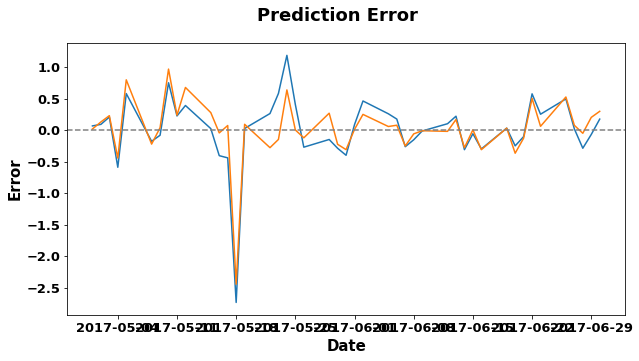

In [13]:
plotSeries([df['PETR4_Close_resid'], df['PETR4_Close_resid'] - predictionsNormSeries],
           plotZeroLine = True,
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Prediction Error', ylabel = 'Error')

In [14]:
xNormAll = np.append(xNormTrain, xNormTest, axis = 0)
predictionsNormAll = bestNormModel.predict(xNormAll)
predictionsNormAll = yNormScaler.inverse_transform(predictionsNormAll)
predictionsNormAll_clean = []
for p in predictionsNormAll:
    predictionsNormAll_clean.extend(p)
predictionsNormAllSeries = pd.Series(predictionsNormAll_clean, index = df[10:].index)

In [15]:
def estimatePDF(series, colors, nBins, overlap = True):
    maximum = minimum = series[0].dropna().mean()
    for s in series:
        maximum = s.dropna().max() if s.dropna().max() > maximum else maximum
        minimum = s.dropna().min() if s.dropna().min() < minimum else minimum

    binCenters = np.linspace(minimum, maximum, nBins)
    if overlap:
        fig, ax = plt.subplots(figsize = (15, 10), nrows = 1, ncols = 1)
    else:
        fig, ax = plt.subplots(figsize = (10, len(series)*5), nrows = len(series), ncols = 1)
    for i in range(len(series)):
        hist, _ = np.histogram(series[i].dropna(), bins = nBins, range=(minimum, maximum), density=True)
        if overlap:
            ax.plot(binCenters, hist, color = colors[i], label = series[i].name)
        else:
            ax[i].plot(binCenters, hist, color = colors[i], label = series[i].name)
            ax[i].grid()
    
    if overlap:
        ax.grid()
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, loc='best')

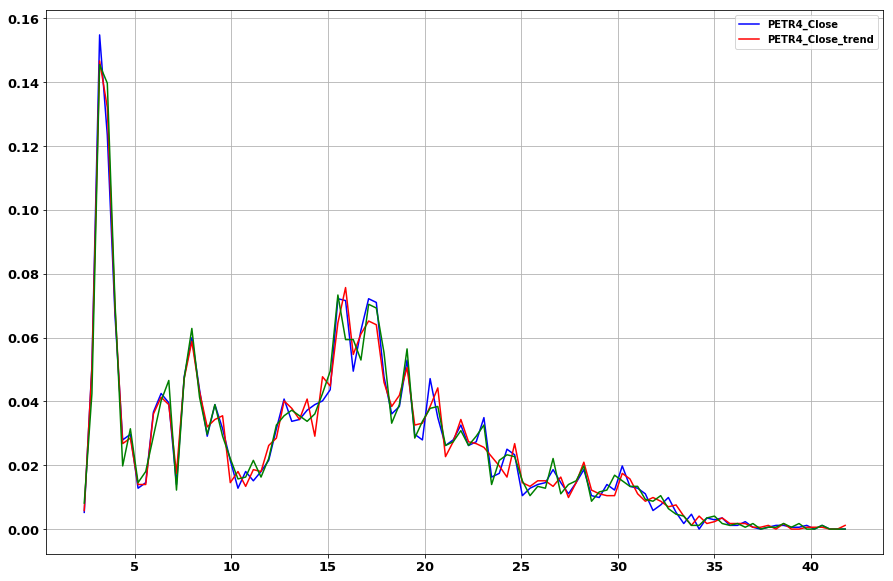

In [16]:
estimatePDF([df['PETR4_Close'][10:], 
            df['PETR4_Close_trend'][10:],
            (df['PETR4_Close_trend'] + predictionsNormAllSeries)[10:]
           ], 
           colors=['b', 'r', 'g'], 
           nBins = 100)

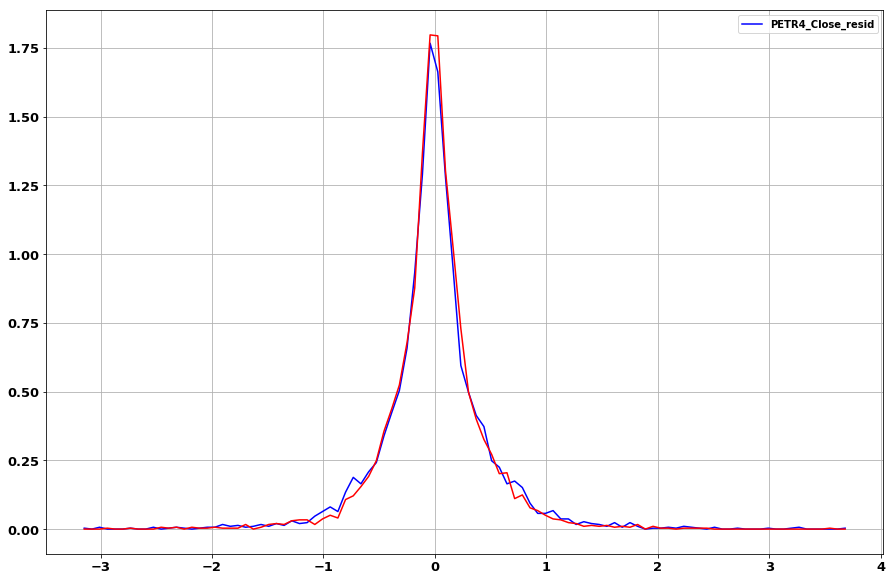

In [17]:
estimatePDF([#df['PETR4_Close'][10:], 
            df['PETR4_Close_resid'][10:],
            ( df['PETR4_Close'][10:] - (df['PETR4_Close_trend'] + predictionsNormAllSeries)[10:])
           ], 
           colors=['b', 'r', 'g'], 
           nBins = 100)

<h3>Retraining same topologies, but using standardization as scaling technique</h3>

In [18]:
from sklearn.preprocessing import StandardScaler

xStdScaler = StandardScaler()
xStdScaler.fit(xTrain)

yStdScaler = StandardScaler()
yStdScaler.fit(yTrain)

xStdTrain = xStdScaler.transform(xTrain)
xStdTest  = xStdScaler.transform(xTest)

yStdTrain = yStdScaler.transform(yTrain)

In [19]:
init_time = time.time()

bestStdValLoss = np.Inf
bestStdFitHistory = None
bestStdHiddenLayer = 1

for nNeurons in range(1, maxNeuronsInHiddenLayer + 1):
    modelCheckpointStd = ModelCheckpoint('./Models/PETR4_MLPi40h{}_std.h5'.format(nNeurons), save_best_only=True)
    for fold in range(nFolds):
        modelStd = Sequential([Dense(nNeurons, activation = 'tanh', input_dim = inputDim),
                               Dense(1, activation = 'linear')
                              ])
        modelStd.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mae'])

        fitHistory = modelStd.fit(xStdTrain, 
                                  yStdTrain, 
                                  epochs = 2000,
                                  verbose = 0,
                                  shuffle = True,
                                  validation_split = 0.15, 
                                  callbacks = [modelCheckpointStd,
                                               earlyStopping])
        
        if min(fitHistory.history['val_loss']) < bestStdValLoss:
            bestStdValLoss = min(fitHistory.history['val_loss'])
            bestStdFitHistory = fitHistory
            bestStdHiddenLayer = nNeurons

end_time = time.time()

print 'Time to fit all models: '+str(end_time-init_time)+' seconds'

Time to fit all models: 4821.08491802 seconds


In [20]:
bestModelStd = load_model('./Models/PETR4_MLPi40h{}_std.h5'.format(bestStdHiddenLayer))
bestModelStd.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1359 (Dense)           (None, 28)                1148      
_________________________________________________________________
dense_1360 (Dense)           (None, 1)                 29        
Total params: 1,177
Trainable params: 1,177
Non-trainable params: 0
_________________________________________________________________


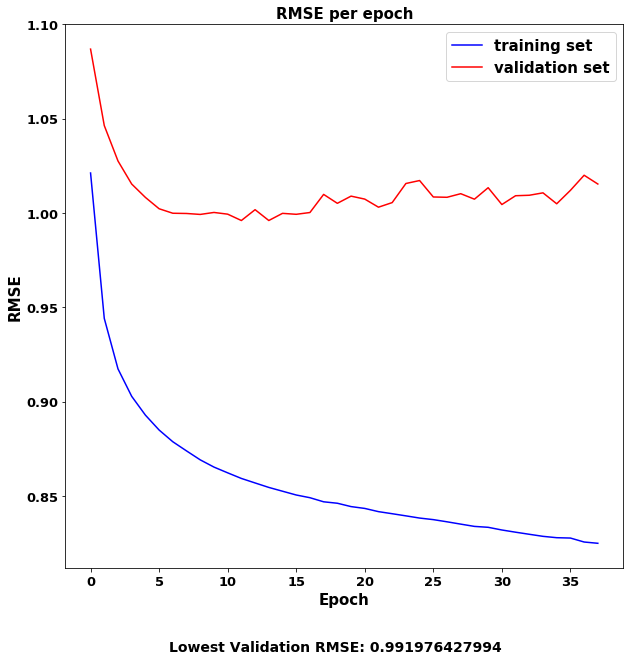

In [21]:
fig, ax = plt.subplots(figsize = (10,10), nrows = 1, ncols = 1)
ax.set_title('RMSE per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
trainigSet, = ax.plot(np.sqrt(bestStdFitHistory.history['loss']), 'b', label = 'trainig set')
validationSet, = ax.plot(np.sqrt(bestStdFitHistory.history['val_loss']), 'r', label = 'validation set')
plt.legend(handles=[trainigSet, validationSet], labels=['training set', 'validation set'], prop={'size': 15})
plt.figtext(0.5,  0.010, 'Lowest Validation RMSE: {}'.format(min(bestStdFitHistory.history['val_loss'])), size = 14, horizontalalignment = 'center')
fig.savefig('{}/{}.{}'.format(saveFigDir, 'PETR4_MLP_std', 'pdf'), bbox_inches='tight')

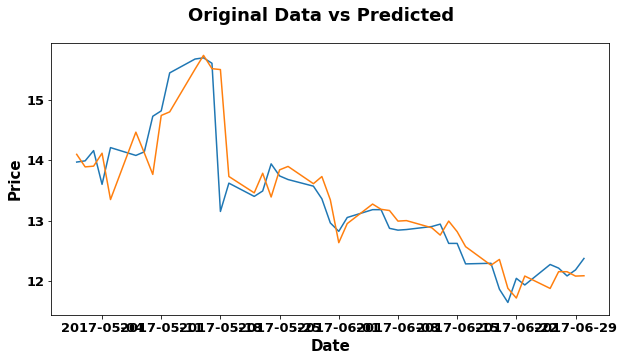

In [22]:
predictionsStd = bestModelStd.predict(xStdTest)
predictionsStd = yStdScaler.inverse_transform(predictionsStd)
predictionsStd_clean = []
for p in predictionsStd:
    predictionsStd_clean.extend(p)
predictionsStdSeries = pd.Series(predictionsStd_clean, index = df['2017'].index)

plotSeries([df['PETR4_Close_trend']+ df['PETR4_Close_resid'], 
#            df['PETR4_Close_trend'],
            df['PETR4_Close_trend'] + predictionsStdSeries],
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Original Data vs Predicted', ylabel = 'Price')

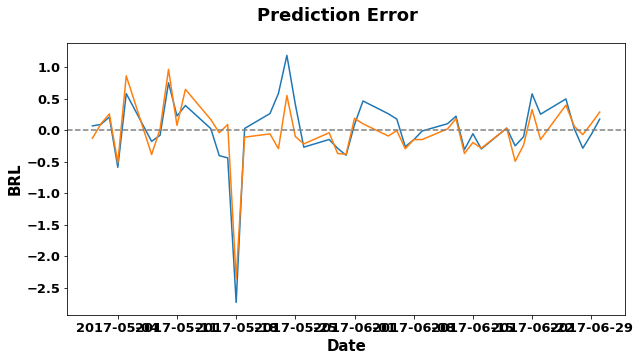

In [23]:
plotSeries([df['PETR4_Close_resid'], (df['PETR4_Close_resid'] - predictionsStdSeries)],
           plotZeroLine = True,
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Prediction Error', ylabel = 'BRL')

<h3>Retraining MLPs using only the delayed series as input, no auxiliar series, for comparative purposes</h3>

In [24]:
xSimpleTrain, ySimpleTrain, xSimpleTest, ySimpleTest = prepData(df = df, 
                                                                columnsToUse = ['PETR4_Close_resid'], columnToPredict = 'PETR4_Close_resid', 
                                                                nDelays = 10, testSetSize = len(df['2017']))

xSimpleScaler = MinMaxScaler()
xSimpleScaler.fit(xSimpleTrain)

ySimpleScaler = MinMaxScaler()
ySimpleScaler.fit(ySimpleTrain)

xSimpleTrain = xSimpleScaler.transform(xSimpleTrain)
xSimpleTest  = xSimpleScaler.transform(xSimpleTest)

ySimpleTrain = ySimpleScaler.transform(ySimpleTrain)

In [25]:
inputDim = xSimpleTrain.shape[1]

nFolds = 10 # number of times a topology will be trained
maxNeuronsInHiddenLayer = 10 # upper limit for number of neurons in hidden layer

bestSimpleValLoss = np.Inf
bestSimpleFitHistory = None
bestSimpleHiddenLayer = 1

init_time = time.time()

for nNeurons in range(1, maxNeuronsInHiddenLayer + 1):
    modelCheckpointSimple = ModelCheckpoint('./Models/PETR4_MLPi10h{}_norm.h5'.format(nNeurons), save_best_only=True)
    for fold in range(nFolds):
        modelSimple = Sequential([Dense(nNeurons, activation = 'tanh', input_dim = inputDim),
                                  Dense(1, activation = 'linear')
                                 ])
        modelSimple.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mae'])

        fitHistory = modelSimple.fit(xSimpleTrain, 
                                     ySimpleTrain, 
                                     epochs = 2000,
                                     verbose = 0,
                                     shuffle = True,
                                     validation_split = 0.15, 
                                     callbacks = [modelCheckpointSimple,
                                                  earlyStopping])
        
        if min(fitHistory.history['val_loss']) < bestSimpleValLoss:
            bestSimpleValLoss = min(fitHistory.history['val_loss'])
            bestSimpleFitHistory = fitHistory
            bestSimpleHiddenLayer = nNeurons

end_time = time.time()

print 'Time to fit all models: '+str(end_time-init_time)+' seconds'

Time to fit all models: 35750.3083198 seconds


In [26]:
bestModelSimple = load_model('./Models/PETR4_MLPi10h{}_norm.h5'.format(bestSimpleHiddenLayer))
bestModelSimple.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1699 (Dense)           (None, 5)                 55        
_________________________________________________________________
dense_1700 (Dense)           (None, 1)                 6         
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


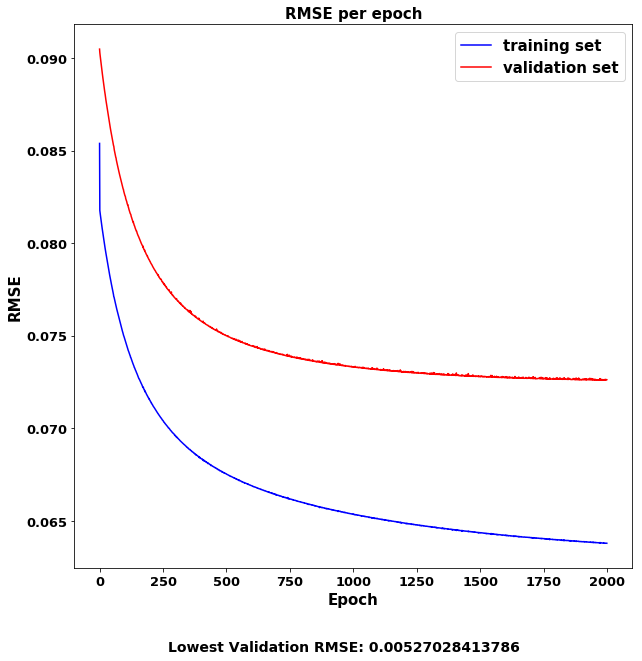

In [27]:
fig, ax = plt.subplots(figsize = (10,10), nrows = 1, ncols = 1)
ax.set_title('RMSE per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
trainigSet, = ax.plot(np.sqrt(bestSimpleFitHistory.history['loss']), 'b', label = 'trainig set')
validationSet, = ax.plot(np.sqrt(bestSimpleFitHistory.history['val_loss']), 'r', label = 'validation set')
plt.legend(handles=[trainigSet, validationSet], labels=['training set', 'validation set'], prop={'size': 15})
plt.figtext(0.5,  0.010, 'Lowest Validation RMSE: {}'.format(min(bestSimpleFitHistory.history['val_loss'])), size = 14, horizontalalignment = 'center')
fig.savefig('{}/{}.{}'.format(saveFigDir, 'PETR4_MLP_simple', 'pdf'), bbox_inches='tight')

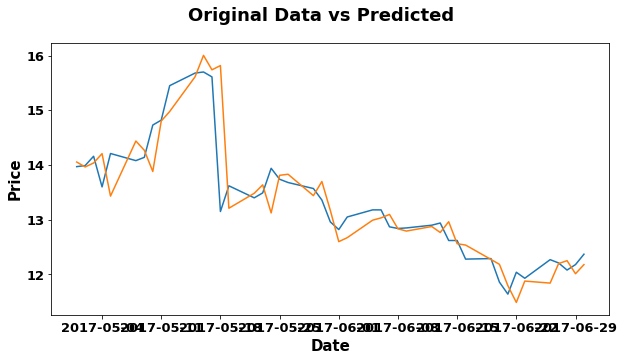

In [28]:
predictionsSimple = bestModelSimple.predict(xSimpleTest)
predictionsSimple = ySimpleScaler.inverse_transform(predictionsSimple)
predictionsSimple_clean = []
for p in predictionsSimple:
    predictionsSimple_clean.extend(p)
predictionsSimpleSeries = pd.Series(predictionsSimple_clean, index = df['2017'].index)

plotSeries([df['PETR4_Close_trend']+ df['PETR4_Close_resid'], 
#            df['PETR4_Close_trend'],
            df['PETR4_Close_trend'] + predictionsSimpleSeries],
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Original Data vs Predicted', ylabel = 'Price')

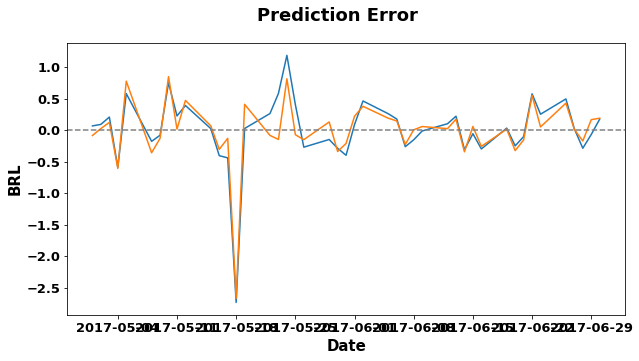

In [29]:
plotSeries([df['PETR4_Close_resid'], (df['PETR4_Close_resid'] - predictionsSimpleSeries)],
           plotZeroLine = True,
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Prediction Error', ylabel = 'BRL')

In [30]:
xNormSimpleAll = np.append(xSimpleTrain, xSimpleTest, axis = 0)
predictionsNormSimpleAll = bestModelSimple.predict(xNormSimpleAll)
predictionsNormSimpleAll = ySimpleScaler.inverse_transform(predictionsNormSimpleAll)
predictionsNormSimpleAll_clean = []
for p in predictionsNormSimpleAll:
    predictionsNormSimpleAll_clean.extend(p)
predictionsNormSimpleAllSeries = pd.Series(predictionsNormSimpleAll_clean, index = df[10:].index)

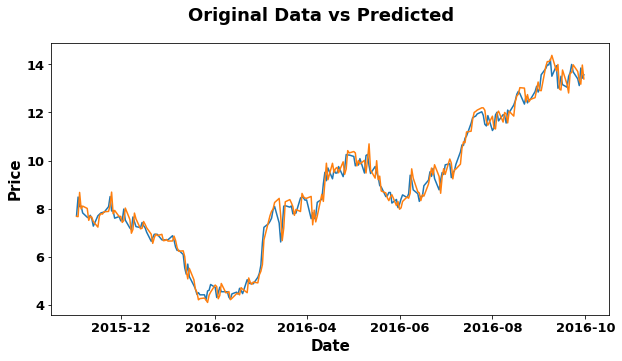

In [31]:
plotSeries([df['PETR4_Close'], 
#            df['PETR4_Close_trend'],
            (df['PETR4_Close_trend'] + predictionsNormSimpleAllSeries)
           ],
           initialPlotDate = '2015-11', finalPlotDate = '2016-09',
           title = 'Original Data vs Predicted', ylabel = 'Price')

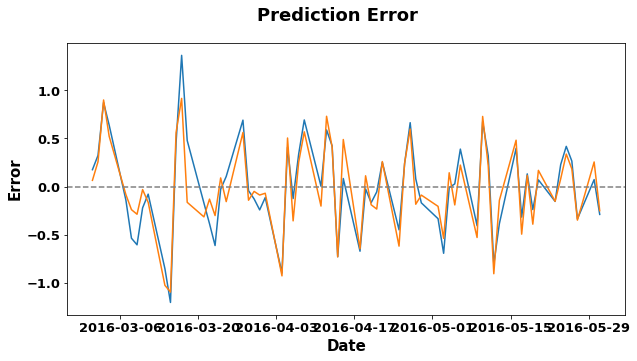

In [32]:
plotSeries([df['PETR4_Close_resid'], (df['PETR4_Close_resid'] - predictionsNormSimpleAllSeries)],
           plotZeroLine = True,
           initialPlotDate = '2016-03', finalPlotDate = '2016-05',
           title = 'Prediction Error', ylabel = 'Error')

<h3>Retraining MLPs using only the delayed series as input, no auxiliar series, and StandardScaler</h3>

In [33]:
xSimpleStdTrain, ySimpleStdTrain, xSimpleStdTest, ySimpleStdTest = prepData(df = df, 
                                                                columnsToUse = ['PETR4_Close_resid'], columnToPredict = 'PETR4_Close_resid', 
                                                                nDelays = 10, testSetSize = len(df['2017']))

xSimpleStdScaler = StandardScaler()
xSimpleStdScaler.fit(xSimpleStdTrain)

ySimpleStdScaler = StandardScaler()
ySimpleStdScaler.fit(ySimpleStdTrain)

xSimpleStdTrain = xSimpleStdScaler.transform(xSimpleStdTrain)
xSimpleStdTest  = xSimpleStdScaler.transform(xSimpleStdTest)

ySimpleStdTrain = ySimpleStdScaler.transform(ySimpleStdTrain)

In [34]:
inputDim = xSimpleTrain.shape[1]

nFolds = 10 # number of times a topology will be trained
maxNeuronsInHiddenLayer = 10 # upper limit for number of neurons in hidden layer

bestSimpleStdValLoss = np.Inf
bestSimpleStdFitHistory = None
bestSimpleStdHiddenLayer = 1

init_time = time.time()

for nNeurons in range(1, maxNeuronsInHiddenLayer + 1):
    modelCheckpointSimpleStd = ModelCheckpoint('./Models/PETR4_MLPi10h{}_std.h5'.format(nNeurons), save_best_only=True)
    for fold in range(nFolds):
        modelSimpleStd = Sequential([Dense(nNeurons, activation = 'tanh', input_dim = inputDim),
                                     Dense(1, activation = 'linear')
                                    ])
        modelSimpleStd.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mae'])

        fitHistory = modelSimpleStd.fit(xSimpleTrain, 
                                     ySimpleTrain, 
                                     epochs = 2000,
                                     verbose = 0,
                                     shuffle = True,
                                     validation_split = 0.15, 
                                     callbacks = [modelCheckpointSimpleStd,
                                                  earlyStopping])
        
        if min(fitHistory.history['val_loss']) < bestSimpleStdValLoss:
            bestSimpleStdValLoss = min(fitHistory.history['val_loss'])
            bestSimpleStdFitHistory = fitHistory
            bestSimpleStdHiddenLayer = nNeurons

end_time = time.time()

print 'Time to fit all models: '+str(end_time-init_time)+' seconds'

Time to fit all models: 38333.1338511 seconds


In [35]:
bestModelSimpleStd = load_model('./Models/PETR4_MLPi10h{}_std.h5'.format(bestSimpleStdHiddenLayer))
bestModelSimpleStd.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1943 (Dense)           (None, 8)                 88        
_________________________________________________________________
dense_1944 (Dense)           (None, 1)                 9         
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


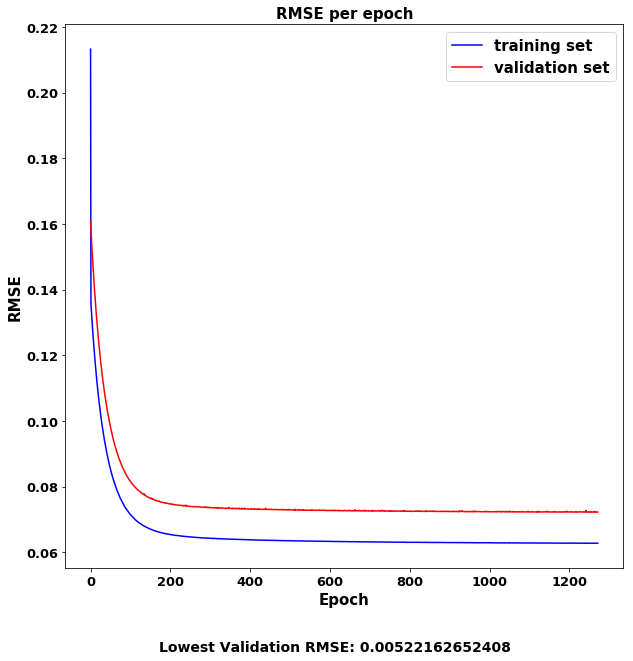

In [36]:
fig, ax = plt.subplots(figsize = (10,10), nrows = 1, ncols = 1)
ax.set_title('RMSE per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
trainigSet, = ax.plot(np.sqrt(bestSimpleStdFitHistory.history['loss']), 'b', label = 'trainig set')
validationSet, = ax.plot(np.sqrt(bestSimpleStdFitHistory.history['val_loss']), 'r', label = 'validation set')
plt.legend(handles=[trainigSet, validationSet], labels=['training set', 'validation set'], prop={'size': 15})
plt.figtext(0.5,  0.010, 'Lowest Validation RMSE: {}'.format(min(bestSimpleStdFitHistory.history['val_loss'])), size = 14, horizontalalignment = 'center')
fig.savefig('{}/{}.{}'.format(saveFigDir, 'PETR4_MLP_simpleStd', 'pdf'), bbox_inches='tight')

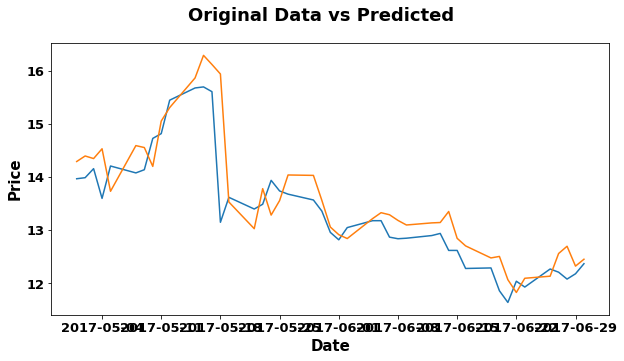

In [37]:
predictionsSimpleStd = bestModelSimpleStd.predict(xSimpleStdTest)
predictionsSimpleStd = ySimpleStdScaler.inverse_transform(predictionsSimpleStd)
predictionsSimpleStd_clean = []
for p in predictionsSimpleStd:
    predictionsSimpleStd_clean.extend(p)
predictionsSimpleStdSeries = pd.Series(predictionsSimpleStd_clean, index = df['2017'].index)

plotSeries([df['PETR4_Close_trend']+ df['PETR4_Close_resid'], 
#            df['PETR4_Close_trend'],
            df['PETR4_Close_trend'] + predictionsSimpleStdSeries],
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Original Data vs Predicted', ylabel = 'Price')

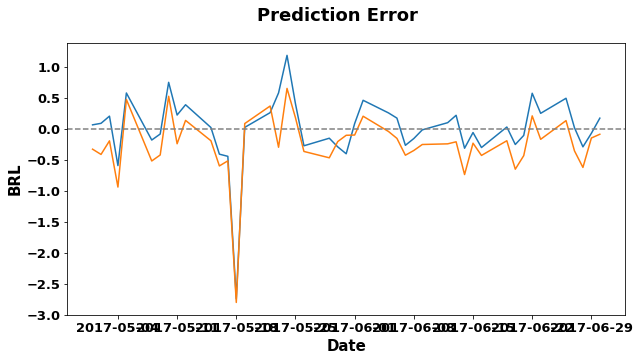

In [38]:
plotSeries([df['PETR4_Close_resid'], (df['PETR4_Close_resid'] - predictionsSimpleStdSeries)],
           plotZeroLine = True,
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Prediction Error', ylabel = 'BRL')